* In this notebook, we tackle a sub class of the task in the ARC dataset.

* These tasks contain the same 'object' shapes in the input and output except that the colour of the objects changes.

* We encode some of the 'core knowledge priors' outlined by Chollet. We then perform a search operation on the 'selecting' functions. These are functions that identify an object in the input by one of its 'core' properties. 

In [1]:
import numpy as np
import pandas as pd
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from scipy import ndimage
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from tqdm import tqdm
import itertools

Using TensorFlow backend.


In [2]:
import json
import os
from os.path import join as path_join


def load_data(path):
    tasks = pd.Series()
    for file_path in os.listdir(path):
        task_file = path_join(path, file_path)

        with open(task_file, 'r') as f:
            task = json.load(f)

        tasks[file_path[:-5]] = task
    return tasks

In [3]:
train_tasks = load_data('../input/abstraction-and-reasoning-challenge/training/')
evaluation_tasks = load_data('../input/abstraction-and-reasoning-challenge/evaluation/')
test_tasks = load_data('../input/abstraction-and-reasoning-challenge/test/')
train_tasks.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


b91ae062    {'train': [{'input': [[6, 7, 0], [0, 6, 6], [0...
b27ca6d3    {'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...
7f4411dc    {'train': [{'input': [[0, 7, 0, 0, 0, 0, 0, 0,...
9d9215db    {'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...
11852cab    {'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...
dtype: object

In [4]:
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_task(task,j=0,k=0):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 4, figsize=(15,15))
    axs[0].imshow(task['train'][j]['input'], cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Train Input')
    axs[1].imshow(task['train'][j]['output'], cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Train Output')
    axs[2].imshow(task['test'][k]['input'], cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Test Input')
    axs[3].imshow(task['test'][k]['output'], cmap=cmap, norm=norm)
    axs[3].axis('off')
    axs[3].set_title('Test Output')
    plt.tight_layout()
    plt.show()

In [5]:
def plot_images(images):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    m = len(images)
    fig, axs = plt.subplots(1, m, figsize=(15,15))
    for i in range(m):
        axs[i].imshow(images[i], cmap=cmap, norm=norm)
        axs[i].axis('off')
        axs[i].set_title('Image' + str(i))
    plt.tight_layout()
    plt.show()

## DSL

In [6]:
class fund_unit:
    
    def __init__(self,colour,position,ambient = -1):
        self.colour = colour
        self.position = position #list of places
        l1 = [x[0] for x in position]
        l2 = [x[1] for x in position]
        a = min(l1)
        corners = get_corners(position)
        self.top_right = corners['top_right']
        self.top_left = corners['top_left']
        self.bottom_left = corners['bottom_left']
        self.bottom_right = corners['bottom_right']
        self.colour = colour
        self.ambient = ambient
        self.right = corners['right']
        self.left = corners['left']
        self.bottom = corners['bottom']
        self.top = corners['top']

In [7]:
def create(colour,position):
    unit = fund_unit(colour,position)
    return(unit)

# Distance functions

In [8]:
def min_steps(unit1,unit2,include_end = 0):
    l = []
    for x in unit1.position:
        for y in unit2.position:
            a = count_steps(x[0],y[0],include_end)
            b = count_steps(x[1],y[1],include_end)
            l.append((a,b))
    l.sort(key = lambda x : abs(x[0]) + abs(x[1]))   
    t = l[0]
    return(np.array([t[0],t[1]]))         

In [9]:
def max_steps(unit1,unit2,include_end = 0):
    l = []
    for x in unit1.position:
        for y in unit2.position:
            a = count_steps(x[0],y[0],include_end)
            b = count_steps(x[1],y[1],include_end)
            l.append((a,b))
    l.sort(key = lambda x : abs(x[0]) + abs(x[1]))   
    t = l[-1]
    #return(l)
    return(np.array([t[0],t[1]]))

In [10]:
def count_steps(a,b,include_end = 0):
    steps = 0
    if include_end == 0:
        if a < b:
            steps = b-a-1
        if a > b:
            steps = b-a+1
    else:
        steps = b-a
    return(steps)    

# Attribute functions

In [11]:
#units is a list
def get_colour_dict(units):
    colours = {}
    for j in range(10):
        colours[j] = []
        for unit in units:
            if unit.colour == j:
                colours[j].append(unit)
        colours[j].sort(key = lambda unit: (unit.top_left[0],unit.top_left[1]))
    return(colours)    

In [12]:
def get_corners(position):
    l1 = [x[0] for x in position]
    l2 = [x[1] for x in position]
    a = min(l1)
    l3 = []
    for x in position:
        if x[0] == a:
            l3.append(x[1])
    b = min(l3)
    c = max(l3)
    corners = {'top_left' : np.array([a,b]),'top_right' : np.array([a,c])}
    a = max(l1)
    for x in position:
        if x[0] == a:
            l3.append(x[1])
    b = min(l3)
    c = max(l3)
    corners['bottom_left'] = np.array([a,b])
    corners['bottom_right'] = np.array([a,c])
    # get the coordinates of the top cell
    a = min(l1)
    l3 = []
    for x in position:
        if x[0] == a:
            l3.append(x[1])
    l3.sort()        
    if len(l3)%2 == 1:
        m = (len(l3)-1)//2
    else:
        m = len(l3)//2
    corners['top'] = np.array([a,l3[m]])
    #coordinates of the bottom cell
    a = max(l1)
    l3 = []
    for x in position:
        if x[0] == a:
            l3.append(x[1])
    l3.sort()        
    if len(l3)%2 == 1:
        m = (len(l3)-1)//2
    else:
        m = len(l3)//2
    corners['bottom'] = np.array([a,l3[m]])    
    #coordinates of the left cell
    a = min(l2)
    l3 = []
    for x in position:
        if x[1] == a:
            l3.append(x[0])
    l3.sort()        
    if len(l3)%2 == 1:
        m = (len(l3)-1)//2
    else:
        m = len(l3)//2
    corners['left'] = np.array([l3[m],a])
    #coordinates of the right cell 
    a = max(l2)
    l3 = []
    for x in position:
        if x[1] == a:
            l3.append(x[0])
    l3.sort()        
    if len(l3)%2 == 1:
        m = (len(l3)-1)//2
    else:
        m = len(l3)//2
    corners['right'] = np.array([l3[m],a])
    return(corners)

In [13]:
def get_size_list(units):
    units.sort(key = lambda u : len(u.position))
    return(units)    

In [14]:
# returns chunks of unit1 which are copies of unit2 after moving it. 
def pattern_matching(unit1,unit2,with_colour = False):
    if with_colour and not unit1.colour == unit2.colour:
        return([])
    else:
        l = []
        matches = []
        y = unit2.position[0]
        for x in unit1.position:
            l.append(x-y)
        s1 = [(a[0],a[1]) for a in unit1.position]        
        s1 = set(s1)
        for z in l:
            p2 = [y + z for y in unit2.position]
            p2 = [(a[0],a[1]) for a in p2]
            p2 = set(p2)
            if p2.issubset(s1):
                p2 = list(p2)
                p2 = [np.array([a[0],a[1]]) for a in p2]
                matches.append([p2,z])
        matches.sort(key = lambda a : abs(a[1][0]) + abs(a[1][1]))
        return(matches)                

In [15]:
# sorts a list of units by size
def sort_by_size(l):
    l.sort(key = lambda u : len(u.position))
    return(l)

In [16]:
def sort_by_position(l,base = 0):
    if base != 3 and base !=7:
        l.sort(key = lambda u : (give_base(u,base)[0],give_base(u,base)[1]))
    if base == 7:
        l.sort(key = lambda u : (give_base(u,base)[1],give_base(u,base)[0]))
    if base == 3:
        l.sort(key = lambda u : (-give_base(u,base)[1],give_base(u,base)[0]))
    return(l)

def give_base(unit,base):
    d = {}
    d[0] = unit.top_left
    d[1] = unit.top
    d[2] = unit.top_right
    d[3] = unit.right
    d[4] = unit.bottom_right
    d[5] = unit.bottom 
    d[6] = unit.bottom_left
    d[7] = unit.left
    return(d[base])

# Change unit in place

In [17]:
def change_colour(l,c):
    for unit in l:
        unit.colour = c
    return(l)

In [18]:
# Build image information

In [19]:
def get_units(img,with_diag = False):
    img = np.array(img)
    r,c = img.shape
    ambient = img.shape
    E = {}
    V = []
    for i in range(r):
        for j in range(c):
            V.append((i,j))
            E[(i,j)] = [] 
    for i in range(r):
        for j in range(c):
            if i-1 >= 0 and img[i-1,j] == img[i,j]:
                    E[(i,j)].append((i-1,j))
            if i+1 <= r-1 and img[i+1,j] == img[i,j]:
                E[(i,j)].append((i+1,j))
            if j-1 >= 0 and img[i,j-1] == img[i,j]:
                E[(i,j)].append((i,j-1))
            if j+1 <= c-1 and img[i,j+1] == img[i,j]:
                E[(i,j)].append((i,j+1))
            if with_diag:    
                if i-1 >= 0 and j-1 >= 0 and img[i-1,j-1] == img[i,j]:
                    E[(i,j)].append((i-1,j-1))
                if i-1 >= 0 and j+1 <= c-1 and img[i-1,j+1] == img[i,j]:
                    E[(i,j)].append((i-1,j+1))
                if i+1 <= r-1 and j-1 >= 0 and img[i+1,j-1] == img[i,j]:
                    E[(i,j)].append((i+1,j-1))
                if i+1 <= r-1 and j+1 <= c-1 and img[i+1,j+1] == img[i,j]:
                    E[(i,j)].append((i+1,j+1))
    parent = DFS(V,E)
    units = []
    for v in parent.keys():
        if len(parent[v]) > 0:
            temp = [np.array([x[0],x[1]]) for x in parent[v]]
            unit = fund_unit(img[v],temp,ambient)
            units.append(unit)
    units.sort(key = lambda unit: (unit.top_left[0],unit.top_left[1]))        
    return(units)

In [20]:
def offset(coordinates,a,b):
    new_x = coordinates[0] + a
    new_y = coordinates[1] + b
    return(np.array([new_x,new_y]))

In [21]:
def DFS(V,E):
    colour = {}
    parent = {}
    for v in V:
        colour[v] = 0
        parent[v] = []
    for v in V:
        if colour[v] == 0:
            DFS_search(v,E,parent[v],colour)
    return(parent)        

In [22]:
def DFS_search(v,E,l,colour):
    l.append(v)
    colour[v] = 1
    for e in E[v]:
        if colour[e] == 0:
            DFS_search(e,E,l,colour)
    colour[v] = 2    

In [23]:
# f returns a list. We want it to act on every element of a list
def do_for_list(l,f):
    t = []
    for x in l:
        t = t + f(x)
    return(t)

# Check contractibility & clear blank space

In [24]:
def get_genus(unit,with_diag = False):
    r,c = unit.ambient
    l = boundary_img(r,c)
    if check_belongs_to(l,unit.position):
        is_a_boundary = True
    else:
        is_a_boundary = False
    #i = 0
    #count = 0
    #while check_belongs_to([l[i]],unit.position):
    #    count += 1
    #    i += 1
    #    if i > len(l)-1:
    #        break
    #if count < 2*c + 2*r - 4:
    #    start_key = l[i]
    #    is_a_boundary = False
    #else:
    #    is_a_boundary = True
    u = fund_unit(1,unit.position,unit.ambient)
    img = concat([u],u.ambient)
    units = get_units(img,with_diag)
    enclosed_area = []
    g = 0 
    for v in units:
        if check_empty_intersection(l,v.position) and check_empty_intersection(v.position,unit.position):
            g += 1
    return(g)  

In [25]:
def check_contractible(unit,with_diag = False):
    g = get_genus(unit,with_diag)
    if g == 0:
        return(True)
    else:
        return(False)

In [26]:
def get_non_contractible(units,with_diag = False,with_background = False):
    non_contract = []
    units = sort_by_size(units)
    if not with_background and units[-1] == 0:
        units = units[:-1]
    for u in units:
        if not check_contractible(u,with_diag):
            non_contract.append(u)
    return(non_contract)        

In [27]:
def get_up_to_homotopy(units):
    t = []
    for u in units:
        if not check_contractible(u):
            t.append(u)
    return(t)        

In [28]:
# removes the blank spaces of the background, no assumption if backgroung even exists.
def get_rid_of_empty_space(img):
    img = np.array(img)
    ambient = np.array(img).shape
    units = get_units(img)
    background = sort_by_size(units)[-1]
    #h = len(background.position) > len(sort_by_size(units)[-2].position)
    r,c = ambient[0],ambient[1]
    non_empty_rows = []
    non_empty_cols = []
    new_img = []
    for i in range(r):
        x = 0
        for j in range(c):
            if img[(i,j)] != background.colour:
                x = 1 
        if x == 1:
            non_empty_rows.append(i) 
    for j in range(c):
        x = 0
        for i in range(r):
            if img[(i,j)] != background.colour:
                x = 1 
        if x == 1:
            non_empty_cols.append(j)
    for i in range(r):
        if i in non_empty_rows:
            new_img.append(img[i])
    new_img = np.transpose(np.array(new_img))
    new_img2 = []
    for j in range(c):
        if j in non_empty_cols:
            new_img2.append(new_img[j])
    new_img2 = np.transpose(np.array(new_img2))
    return(new_img2)

## Check grid

In [29]:
def check_identical(l):
    u0 = l[0]
    t = 0
    for u in l:
        if len(u.position) == len(u0.position):
            p = pattern_matching(u,u0)
            if len(p) >= 1:
                t += 1
    if t == len(l):
        return(True)
    else:
        return(False)

In [30]:
def check_grid(img,get_diag = False):
    img = np.array(img)
    ambient = np.array(img).shape
    units = sort_by_size(get_units(img,get_diag))
    for u in units:
        c = 0
        v = []
        for w in units:
            if w != u:
                v.append(w)
        r = {}
        for w in v:
            x = w.top_left
            if x[0] in r.keys():
                r[x[0]].append(w)
            else:
                r[x[0]] = [w]
        temp = []
        for k in r.keys():
            temp.append(len(r[k]))
        if len(set(temp)) > 1:
            c = 1 
        for k in r.keys():
            if not check_identical(r[k]):
                c = 1
        if c == 0:
            return([u])
    return([]) 

In [31]:
# background is the unit of largest size

def get_background(img,get_diag = False):
    img = np.array(img)
    ambient = np.array(img).shape
    units = get_units(img,get_diag)
    background = sort_by_size(units)[-1]
    return(background)

 ## collecting units that are surrounded

In [32]:
def check_actual_coord(x,y,r,c):
    if x >= 0 and x <= r-1 and y >= 0 and y <= c-1:
        return(True)
    else:
        return(False)

In [33]:
def udlr(x,r,c):
    a,b = x[0],x[1]
    l = []
    x_up = [a-1,b]
    x_down = [a+1,b]
    x_right = [a,b+1]
    x_left = [a,b-1]
    t = [x_up,x_down,x_right,x_left]
    for i in range(4):
        if check_actual_coord(t[i][0],t[i][1],r,c):
            l.append(np.array(t[i]))
    return(l)       

In [34]:
def is_surrounded(u1,u2):
    r,c = u1.ambient
    val = True
    for x in u1.position:
        t = udlr(x,r,c)
        m = len(t)
        if m < 4:
            val = False
        for i in range(m):
            if not check_belongs_to([t[i]],u1.position):
                if not check_belongs_to([t[i]],u2.position):
                    val = False
    return(val)                        

In [35]:
t = np.array([[1,1,1,1],[1,1,0,1],[1,0,0,1],[1,1,1,1]])
units = sort_by_size(get_units(t))

In [36]:
# Returns a dict - surrounded, where surrounded[u] is the list of units v surrounded by u.

def get_surrounded(units):
    surrounded = {}
    for u in units:
        surrounded[u] = []
        for v in units:
            if is_surrounded(v,u):
                surrounded[u].append(v)
    return(surrounded)            

In [37]:
def surrounded_list(units):
    surrounded = []
    d = get_surrounded(units)
    l = []
    for k in d.keys():
        l = l + d[k]
    return(l)    

## Get shapes which are contained in other shapes

In [38]:
def boundary_img(r,c):
    l = []
    for j in range(c):
        l.append(np.array([0,j]))
    for j in range(r):
        l.append(np.array([j,c-1]))
    for j in range(c):
        l.append(np.array([r-1,j]))
    for j in range(r):
        l.append(np.array([j,0]))
    return(l)    

In [39]:
def get_intersection(l1,l2):
    l11 = [(x[0],x[1]) for x in l1]
    l22 = [(x[0],x[1]) for x in l2]
    l = list(set(l11)&set(l22))
    l = [np.array(x) for x in l]
    return(l)

In [40]:
def check_empty_intersection(l1,l2):
    l = get_intersection(l1,l2)
    if len(l) > 0:
        return(False)
    else:
        return(True)

In [41]:
# Assume the container is not black

def get_enclosed_area(unit):
    r,c = unit.ambient
    l = boundary_img(r,c)
    i = 0
    count = 0
    while check_belongs_to([l[i]],unit.position):
        count += 1
        i += 1
        if i > len(l)-1:
            break
    if count < 2*c + 2*r - 4:
        start_key = l[i]
        is_a_boundary = False
    else:
        is_a_boundary = True
    u = fund_unit(1,unit.position,unit.ambient)
    img = concat([u],u.ambient)
    units = get_units(img)
    enclosed_area = []
    if is_a_boundary:
        for v in units:
            if check_belongs_to([v.top_left],[u.top_left]):
                enclosed_area += v.position                
    if len(units) > 2 and not is_a_boundary:
        for v in units:
            if not check_belongs_to([v.top_left],[u.top_left]) and check_empty_intersection(l,v.position):
                enclosed_area += v.position
    return(enclosed_area)            

In [42]:
def contained_list(units):
    contained = []
    enclosed_area = []
    for u in units:
        if u.colour != 0:
            enclosed_area += get_enclosed_area(u)
    for v in units:
        if check_belongs_to(v.position,enclosed_area):
            contained.append(v)
    return(contained)                   

In [43]:
def contained_in(units):
    d = {}
    l = detect_regular_non_contractible(units)
    for u in l:
        d[u] = []
        x = u.top_left
        y = u.bottom_right
        l1 = list(range(x[0],y[0]+1))
        l2 = list(range(x[1],y[1]+1))
        temp = list(itertools.product(l1,l2))
        p = []
        for t in temp:
            p.append(np.array([t[0],t[1]]))
        pdiff = []    
        for v in p:
            r0 = 0
            for z in u.position:
                if v[0] == z[0] and v[1] == z[1]:
                    r0 += 1
            if r0 == 0:
                pdiff.append(v)
        udiff = fund_unit(0,pdiff,u.ambient)
        for v in units:
            if check_belongs_to(v.position,u.position):
                d[u].append(v)
    return(d)            

## Extracting simple shapes

In [44]:
def is_regular(unit):
    x = unit.top_left
    y = unit.bottom_right
    l1 = list(range(x[0],y[0]+1))
    l2 = list(range(x[1],y[1]+1))
    temp = list(itertools.product(l1,l2))
    p = []
    for t in temp:
        p.append(np.array([t[0],t[1]]))
    u0 = fund_unit(0,p,unit.ambient)
    if len(p) == len(unit.position):
        l = pattern_matching(u0,unit)
        if len(l) > 0:
            if len(l1) == len(l2):
                return('square')
            if len(l1) == 1 and len(l2) > len(l1):
                return('vertical line')
            if len(l2) == 1 and len(l1) > len(l2):
                return('horizontal line')
            if len(l1) > len(l2):
                return('horizontal rectangle')
            if len(l2) > len(l1):
                return('vertical rectangle')
    return('-1')        

In [45]:
def get_regular_shapes(units):
    d = {}
    d['square'] = []
    d['vertical line'] = []
    d['horizontal line'] = []
    d['horizontal rectangle'] = []
    d['vertical rectangle'] = []
    d['-1'] = []
    for u in units:
        d[is_regular(u)].append(u)
    return(d)   

In [46]:
# returns a dict whose keys are elements of the list 'units' and whose values are equivalence classes coded as integers or the list of equivalent shapes.  

def shape_equivalences(units,return_lists = True,remove_background = False): 
    #img = np.array(img)
    #ambient = np.array(img).shape
    units = sort_by_size(units)
    if remove_background:
        units = units[:-1]    
    d = {}
    d[units[0]] = []
    is_key = {}
    for u in units:
        is_key[u] = False
    for u in units:
        c = 0
        for v in units:
            if is_key[v]:
                if len(u.position) == len(v.position):
                    l = pattern_matching(u,v)
                    if len(l) > 0:
                        c += 1
                        d[v].append(u)
        if c == 0:
            d[u] = [u]
            is_key[u] = True
    m = len(d.keys())
    shape_equivalences = {}
    for j,key in enumerate(d.keys()):
        for u in d[key]:
            shape_equivalences[u] = j
    if return_lists:
        return(d)
    else:
        return(shape_equivalences)

In [47]:
def get_task_num(img,task):
    m = len(task['train'])
    for i in range(m):
        if np.all(img == task['train'][i]['input']):
            return(i)

In [48]:
# Returns list of units of an image which also occur in all other images of the training set. num = -1 when img is the test image

def common_shapes_across_images(img,task,img_units,num):
    #if num == -1:
    #    num = get_task_num(img,task)
    m = len(task['train'])
    all_units = []
    task_number = {}
    for i in range(m):
        if i != num:
            units = get_units(task['train'][i]['input'])
        else:
            units = img_units
        for u in units:
            task_number[u] = i
        all_units += units
    if num == -1:
        units = img_units
        all_units += img_units
        for u in units:
            task_number[u] = i
    d = shape_equivalences(all_units) 
    shapes_across_images = []
    for x in d.keys():
        l = [task_number[y] for y in d[x]]
        if len(set(l)) == m:
            shapes_across_images.append(x)
    final_list = []
    for x in shapes_across_images:
         for u in d[x]:
                if task_number[u] == num:
                    final_list.append(u)
    return(final_list)       

In [49]:
def shape_equivalences_counts(units,remove_background = False):
    d = {}
    s = shape_equivalences(units,True,remove_background)
    for x in s.keys():
        m = len(s[x])
        if m in d.keys():
            d[m] += s[x]
        else:
            d[m] = s[x]
    return(d)        

In [50]:
# checks if l1 is a subset of l2. Both are lists of np arrays of length 2.
def check_belongs_to(l1,l2):
    r = 0 
    for z in l1:
        for x in l2:
            if x[0] == z[0] and x[1] == z[1]:
                r += 1
    if r == len(l1):
        return(True)
    else:
        return(False)

In [51]:
def check_this_please(u,x1,x2):
    l1 = list(range(x1[0],x2[0]+1))
    l2 = []
    for t in l1:
        l2.append(np.array([t,x1[1]]))
    if check_belongs_to(l1,u.position):
        count = 1
    else:
        count = 0
    return(count)           

In [52]:
import itertools
# selects the regular non contractible elements of units i.e. those elements of the list units whose hole is a regular object. 

def detect_regular_non_contractible(units):
    #img = np.array(img)
    #ambient = np.array(img).shape
    units = sort_by_size(units)
    regular_non_contractible = []
    for u in units:
        x = u.top_left
        y = u.bottom_right
        l1 = list(range(x[0],y[0]+1))
        l2 = list(range(x[1],y[1]+1))
        temp = list(itertools.product(l1,l2))
        p = []
        for t in temp:
            p.append(np.array([t[0],t[1]]))
        pdiff = []    
        for v in p:
            r0 = 0
            for z in u.position:
                if v[0] == z[0] and v[1] == z[1]:
                    r0 += 1
            if r0 == 0:
                pdiff.append(v)
        if len(pdiff) > 0:        
            udiff = fund_unit(0,pdiff,u.ambient) 
            u0 = fund_unit(0,p,u.ambient)
            s = is_regular(udiff)
            if s != '-1':
                count = 0
                x1 = udiff.top_left
                x2 = udiff.top_right
                l1 = list(range(x1[1],x2[1]+1))
                l2 = []
                for t in l1:
                    l2.append(np.array([x1[0]-1,t]))
                if check_belongs_to(l2,u.position):
                    count += 1
                x1 = udiff.top_right
                x2 = udiff.bottom_right
                l1 = list(range(x1[0],x2[0]+1))
                l2 = []
                for t in l1:
                    l2.append(np.array([t,x1[1]+1]))
                if check_belongs_to(l2,u.position):
                    count += 1 
                x1 = udiff.bottom_left
                x2 = udiff.bottom_right
                l1 = list(range(x1[1],x2[1]+1))
                l2 = []
                for t in l1:
                    l2.append(np.array([x1[0]+1,t]))
                if check_belongs_to(l2,u.position):
                    count += 1    
                x1 = udiff.top_left
                x2 = udiff.bottom_left
                l1 = list(range(x1[0],x2[0]+1))
                l2 = []
                for t in l1:
                    l2.append(np.array([t,x1[1]-1]))
                if check_belongs_to(l2,u.position):
                    count += 1
                if count == 4:
                    regular_non_contractible.append(u)
    return(regular_non_contractible)       

## Filter by sizes

In [53]:
def filter_by_size(units):
    f = {}
    for j in range(1,7):
        f[j] = []
    for u in units:
        if len(u.position) < 6:
            f[len(u.position)].append(u)
        else:
            f[6].append(u)
    return(f)        

# Assembling image from units

In [54]:
def concat(l,ambient,background = 0):
    r,c = ambient
    a = np.full(ambient,background)
    for x in l:
        for z in x.position:
            if z[0] >= 0 and z[0] <= r-1 and z[1] >= 0 and z[1] <= c-1:
                a[z[0],z[1]] = x.colour
    return(a)        

# Get easier sub-collection of the tasks

In [55]:
def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])

def get_equals(task_series):
    l = []
    for j in task_series.index:
        if input_output_shape_is_same(task_series[j]):
            l.append(j)
    return(l)        

In [56]:
l_input_output_same_size = get_equals(train_tasks)
l_input_output_same_size.sort()

In [57]:
# convert a list of np arrays to tuples
def convert_to_tuple(t):
    s = [(a[0],a[1]) for a in t]
    return(s)

In [58]:
# count those images where one must only colour match
l_colour_match_no_diag = []
for index in l_input_output_same_size:
    task = train_tasks[index]
    c = 0
    for example in task['train']:
        units_input = get_units(np.array(example['input']))
        units_output = get_units(np.array(example['output']))
        if len(units_input) == len(units_output):
            sub_count = 0
            for u in units_input:
                s1 = set(convert_to_tuple(u.position))
                for v in units_output:
                    s2 = set(convert_to_tuple(v.position))
                    if s1 == s2:
                        sub_count += 1
            if sub_count == len(units_input):
                c += 1
        if c == len(task['train']):        
            l_colour_match_no_diag.append(index) 

## Inference

In [59]:
# outputs a dict with the following encoding : 
# 0 --> all units
# 1 --> non contractible objects
# 2 --> surrounded_list
# 3 --> contained_in list
# 4 --> squares
# 5 --> vertical_line
# 6 --> horizontal line
# 7 --> horizontal rectangle
# 8 --> vertical rectangle
# 9 --> -1 (irregular shape)
# 10 --> regular shapes (union of 14,15,16,17,18) 
# 11 --> regular non contractible units
# 12 --> List of shapes with no doubles
# 13 --> shapes which are doubled
# 14 --> Shapes which are trebled
# 15 --> Shapes that appear in all train inputs
# 16 --> Shapes of size 1
# 17 --> Shapes of size 2
# 18 --> Shapes of size 3
# 19 --> Shapes of size 4
# 20 --> Shapes of size 5
# 21 --> Shapes of size greater than 5
# 22 --> Shapes of size greater than 1
# All negative keys are complements of the corresponding positive keys

def get_lists(img,task = None,num = -1,with_diag = False):
    list_dict = {}
    img = np.array(img)
    ambient = np.array(img).shape
    units = get_units(img,with_diag)
    list_dict[0] = units
    #c_dict = get_colour_dict(units)
    #for i in range(10):
    #    list_dict[i+1] = c_dict[i]
    #t = get_up_to_homotopy(units)
    list_dict[1] = get_non_contractible(units,with_diag,False)
    list_dict[2] = surrounded_list(units)
    list_dict[3] = contained_list(units)
    shape_d = get_regular_shapes(units)
    list_dict[4] = shape_d['square']
    list_dict[5] = shape_d['vertical line']
    list_dict[6] = shape_d['horizontal line']
    list_dict[7] = shape_d['horizontal rectangle']
    list_dict[8] = shape_d['vertical rectangle']
    list_dict[9] = shape_d['-1']
    list_dict[10] = list_dict[4] + list_dict[5] + list_dict[6] + list_dict[7] + list_dict[8]
    #for count,i in enumerate(range(14,21)):
    #    d_temp = get_colour_dict(list_dict[i])
    #    t = extract_lists_from_dict(d_temp)
    #    for j in range(10):
    #        list_dict[21+(count*10)+j] = t[j]
    list_dict[11] = detect_regular_non_contractible(units)
    shape_counts = shape_equivalences_counts(units,True)
    for i in range(1,4):
        if i not in shape_counts.keys():
            shape_counts[i] = []
    for i in range(1,4):
        list_dict[11+i] = shape_counts[i]
    list_dict[15] = common_shapes_across_images(img,task,units,num)
    f = filter_by_size(units)
    for j in range(1,7):
        list_dict[15+j] = f[j]
    list_dict = get_list_dict_complements(units,list_dict) 
    return(list_dict)    

In [60]:
def get_list_dict_complements(units,list_dict):
    e = {}
    for i in list_dict.keys():
        if i > 0:
            t = list(set(units) - set(list_dict[i]))
            e[-i] = t
    for j in e.keys():
        list_dict[j] = e[j]
    return(list_dict)        

In [61]:
def extract_lists_from_dict(d):
    t = []
    for x in d.keys():
        t.append(d[x])
    return(t)    

list of possible sortings : 

0 - 7 --> sort_by_position(_ , base = i)

8 --> sort_by_size

possible templates : 

0 - l[0]

1 - l[1]

2 - l[2]

3 - l[3]

4 - l[-1]

5 - l[-2]

6 - l[-3]

7 - l[-4]

8 - l[1:]

9 - l[2:]

10 - l[3:]

11 - l[:-1]

12 - l[:-2]

13 - l[-3]

14 - move in even indices

15 - move in odd indices

16 - move in multiples of 3

17 - get middle element of list

18 - get start, middle, end

19 - whole list


In [62]:
def move_in_evens(l):
    m = len(l)
    if m > 0:
        r = []
        c = 0
        while c < m:
            r.append(c)
            c += 2
        l = np.array(l)
        l = list(l[r])
        return(l)
    else:
        return([])

In [63]:
def move_in_odds(l):
    m = len(l)
    if m > 0:
        r = []
        c = 1
        while c < m:
            r.append(c)
            c += 2
        l = np.array(l)
        l = list(l[r])
        return(l)
    else:
        return([])

In [64]:
def move_in_3s(l):
    m = len(l)
    if m > 0:
        r = []
        c = 0
        while c < m:
            r.append(c)
            c += 3
        l = np.array(l)
        l = list(l[r])
        return(l)
    else:
        return([])

In [65]:
def middle(l):
    m = len(l)
    if m > 0:
        if m%2 == 0:
            return([l[m//2]])
        if m%2 == 1:
            t = (m-1)//2
            return([l[t]])
    else:
        return([])

In [66]:
def start_mid_end(l):
    if len(l) > 0:
        mid = middle(l)[0]
        return([l[0],mid,l[-1]])
    else:
        return([])

In [67]:
def template_sublist(l,template):
    d = {}
    m = len(l)
    for i in range(4):
        if m > i:
            d[i] = [l[i]]
        else:
            d[i] = []
    for i in range(1,5):
        if m >= i:
            d[3+i] = [l[-i]]
        else:
            d[3+i] = []        
    d[8]= l[1:]
    d[9]= l[2:]
    d[10]= l[3:]
    d[11]= l[:-1]
    d[12]= l[:-2]
    d[13]= l[:-3]
    d[14] = move_in_evens(l)
    d[15] = move_in_odds(l)
    d[16] = move_in_3s(l)
    d[17] = middle(l)
    d[18] = start_mid_end(l)
    d[19] = l
    return(d[template])         

In [68]:
def sorting_list(l,sorting_type):
    if sorting_type <= 7:
        return(sort_by_position(l,sorting_type))
    if sorting_type == 8:
        return(sort_by_size(l))

In [69]:
# sorting_type -- is an int from 0 --> 8
# template -- is an int from 0 --> 18
# colour_filter -- is an int from 0 --> 10 where 0 to 9 correspond to colours and 10 is no colour filter. 

def get_list_selection(l,sorting_type,template,colour_filter):
    l = sorting_list(l,sorting_type)
    l = template_sublist(l,template)
    c_dict = get_colour_dict(l)
    if colour_filter < 10:
        t = c_dict[colour_filter]
    else:
        t = l
    return(t)

In [70]:
def identify_generic_list(l,img,task,num,with_diag = False):
    r = []
    list_dict = get_lists(img,task,num,with_diag)
    for i in list_dict.keys():
        for j in range(9):
            for k in range(20):
                for m in range(11):
                    temp = get_list_selection(list_dict[i],j,k,m)
                    #print(temp)
                    if is_equal(temp,l):
                        r.append((i,j,k,m))
    return(r)

In [71]:
def is_equal(l1,l2):
    count1 = 0
    count2 = 0
    m1 = len(l1)
    m2 = len(l2)
    if m1 == 0 and m2 > 0:
        return(False)
    if m1 > 0 and m2 == 0:
        return(False)    
    for u in l1:
        for v in l2:
            x = [(a[0],a[1]) for a in u.position]
            y = [(b[0],b[1]) for b in v.position]
            if set(x) == set(y) and u.colour == v.colour:
                count1 +=1 
    for u in l2:
        for v in l1:
            x = [(a[0],a[1]) for a in u.position]
            y = [(b[0],b[1]) for b in v.position]
            if set(x) == set(y) and u.colour == v.colour:
                count2 +=1   
    if count1 == len(l1) and count2 == len(l2):
        return(True)
    else:
        return(False)

In [72]:
def get_colour_change_dict(task,task_number):
    img_in = task['train'][task_number]['input']
    img_out = task['train'][task_number]['output']
    img_in = np.array(img_in)
    ambient = img_in.shape
    img_out = np.array(img_out)
    units_in = sort_by_position(get_units(img_in),0)
    units_out = sort_by_position(get_units(img_out),0)
    m = len(units_in)
    colour_diffs = {}
    for i in range(m):
        if units_in[i].colour != units_out[i].colour:
            if units_out[i].colour not in colour_diffs.keys():
                colour_diffs[units_out[i].colour] = [units_in[i]]
            else:
                colour_diffs[units_out[i].colour].append(units_in[i])
    return(colour_diffs)            

In [73]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [74]:
def get_unique_dict_values(d):
    e = {}
    for x in d.keys():
        temp = d[x]
        for y in d.keys():
            if x != y:
                temp = list(set(temp) - set(d[y]))
        e[x] = temp
    return(e)    

In [75]:
def whittle_candidates_down(task,task_number,colour_diff_solutions,with_diag = False):
    img = np.array(task['train'][task_number]['input'])
    list_dict = get_lists(img,task,task_number,with_diag)
    colour_diff =  get_colour_change_dict(task,task_number)
    for c in colour_diff.keys():
        if c in colour_diff_solutions.keys():
            temp = colour_diff_solutions[c]
        else:
            temp = []
        p = len(temp)
        if p == 0:
            img = np.array(task['train'][task_number]['input'])
            colour_diff_solutions[c] = identify_generic_list(colour_diff[c],img,task,task_number,with_diag)
        else:
            temp1 = []
            for i in range(p):
                a,b,c1,d = temp[i]
                t = get_list_selection(list_dict[a],b,c1,d)
                if is_equal(t,colour_diff[c]):
                    temp1.append(temp[i])
            colour_diff_solutions[c] = temp1
    e = get_unique_dict_values(colour_diff_solutions)        
    return(e) 

In [76]:
def training_algo(task,with_diag = False):
    m = len(task['train'])
    colour_diff = get_colour_change_dict(task,0)
    img = np.array(task['train'][0]['input'])
    colour_diff_solutions = {}
    for c in colour_diff.keys():
        l_c = colour_diff[c]
        solutions = identify_generic_list(l_c,img,task,0,with_diag)
        colour_diff_solutions[c] = solutions
    #return(colour_diff_solutions)    
    for i in range(1,m):
        colour_diff_solutions = whittle_candidates_down(task,i,colour_diff_solutions,with_diag)
    for i in range(m-1,-1,-1):
        colour_diff_solutions = whittle_candidates_down(task,i,colour_diff_solutions,with_diag)
    return(colour_diff_solutions)

In [77]:
def collect_predictions(task,with_diag = False):
    colour_diff_solutions = training_algo(task,with_diag)
    preds = []
    m = len(task['test'])
    for i in range(m):
        img_out = assemble_test(task,i,colour_diff_solutions,with_diag)
        preds.append(img_out)    
    return(preds)    

In [78]:
def assemble_test(task,task_number,colour_diff_solutions,with_diag = False):
    img = np.array(task['test'][task_number]['input'])
    ambient = img.shape
    list_dict = get_lists(img,task,-1,with_diag)
    output_units = []
    for c in colour_diff_solutions.keys():
        if len(colour_diff_solutions[c]) > 0:
            #x,y,z = colour_diff_solutions[c][0]
            #temp = get_list_selection(list_dict[x],y,z)
            temp = filter_solutions(list_dict,colour_diff_solutions,c)
        else:
            temp = []
        for t in temp:
            t.colour = c
        output_units += temp
    # Get all units    
    units = get_list_selection(list_dict[0],0,19,10)
    other_units = []
    m = len(output_units)
    if m == 0:
        other_units = units
    else:    
        for u in units:
            c = 0
            for v in output_units:
                if not is_equal([u],[v]):
                    c += 1
            if c == m:
                other_units.append(u)
    output_units = other_units + output_units            
    img_out = concat(output_units,ambient)    
    return(img_out)

In [79]:
def filter_solutions(list_dict,colour_diff_solutions,c):
    e = {}
    for x in colour_diff_solutions[c]:
        s = get_list_selection(list_dict[x[0]],x[1],x[2],x[3])
        s = sort_by_position(s,0)
        s = tuple(s)
        if s in e.keys():
            e[s] += 1
        else:
            e[s] = 1
    l = list(e.keys())
    l.sort(key = lambda x : e[x])
    t = list(l[-1])
    return(t)        

## Experiment with specific tasks

In [80]:
task = train_tasks[l_colour_match_no_diag[31]]
img = task['train'][0]['input']

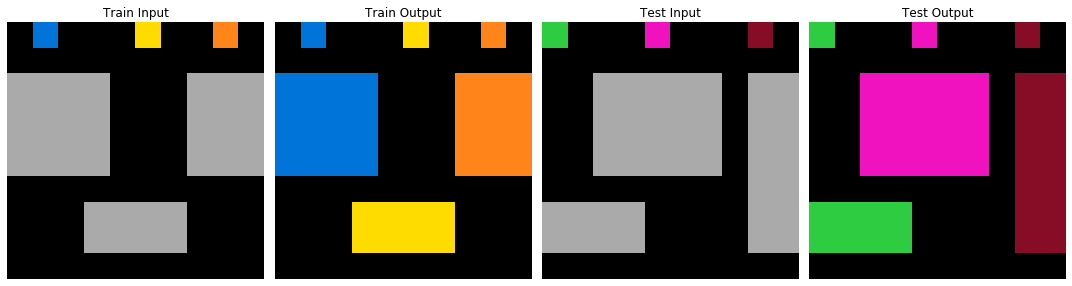

In [81]:
plot_task(task,1)

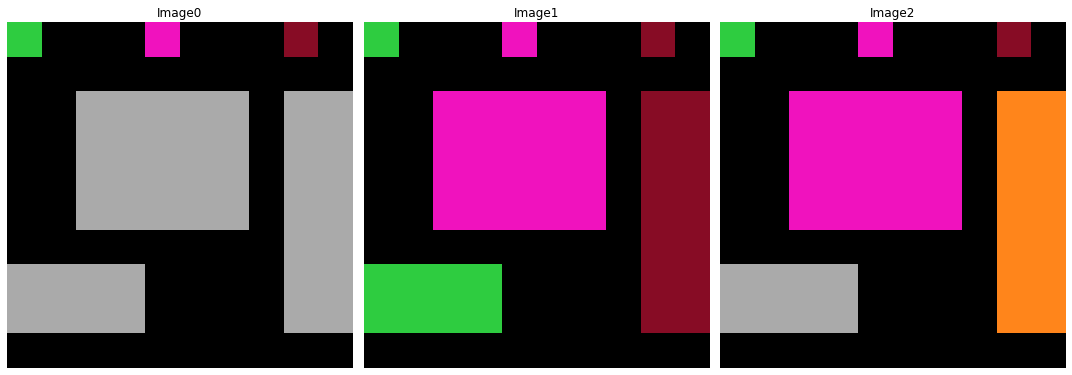

In [82]:
test_pred = collect_predictions(task,True)[0]
plot_images([task['test'][0]['input'],task['test'][0]['output'],test_pred])

## Submission

In [83]:
def check_colour_match(task):
    c = 0
    for example in task['train']:
        units_input = get_units(np.array(example['input']))
        units_output = get_units(np.array(example['output']))
        if len(units_input) == len(units_output):
            sub_count = 0
            for u in units_input:
                s1 = set(convert_to_tuple(u.position))
                for v in units_output:
                    s2 = set(convert_to_tuple(v.position))
                    if s1 == s2:
                        sub_count += 1
            if sub_count == len(units_input):
                c += 1
    if c == len(task['train']): 
        return(True)
    else:
        return(False)

In [84]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def make_prediction(tasks):
    result = pd.Series()
    for idx, task in tqdm(tasks.iteritems()):
        if input_output_shape_is_same(task) and check_colour_match(task):
            pred = collect_predictions(task)
        else:
            pred = [el['input'] for el in task['test']]
        for i, p in enumerate(pred):
            result[f'{idx}_{i}'] = flattener(np.array(p).tolist())
    return result

In [85]:
submission = make_prediction(test_tasks)
submission.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.
100it [23:55, 14.36s/it]


19bb5feb_0    |000000000000000|000000000000000|0000000000000...
358ba94e_0    |0111110000000000000|0111010001111100000|01111...
2753e76c_0    |0000008800000000|0333008800000000|03330000003...
27a77e38_0    |912849821|443127679|216978436|986342917|55555...
09c534e7_0    |000000000000000000000000000000|00000000111110...
dtype: object

In [86]:
submission = submission.reset_index()
submission.columns = ['output_id', 'output']
submission.to_csv('submission.csv', index=False)
submission

,output_id,output
0,19bb5feb_0,|000000000000000|000000000000000|0000000000000...
1,358ba94e_0,|0111110000000000000|0111010001111100000|01111...
2,2753e76c_0,|0000008800000000|0333008800000000|03330000003...
3,27a77e38_0,|912849821|443127679|216978436|986342917|55555...
4,09c534e7_0,|000000000000000000000000000000|00000000111110...
...,...,...
99,310f3251_0,|0040|0000|0000|4000|
100,21f83797_0,|0000000000000|0000200000000|0000000000000|000...
101,0a1d4ef5_0,|550008500888080055050580000008|88550800580058...
102,0a2355a6_0,|00000000000000000|00111100000001110|001001001...
